In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras

%matplotlib inline

# load data and train a simple model

In [2]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print "dimension de las imagenes y las clases", X.shape, y.shape

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
X_train = X_train
X_test  = X_test
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print X_train.shape, y_train_oh.shape

dimension de las imagenes y las clases (1500, 784) (1500,)
(1200, 784) (1200, 10)


In [3]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K

In [4]:
def get_model(input_dim=784, output_dim=10, layer_sizes=[10]*6, activation="relu", sigma=1):
    
    clear_session()
    model = Sequential()

    model.add(Dense(layer_sizes[0], activation=activation, input_dim=input_dim, name="Layer_%02d_Input"%(0)))
   
    for i, hsize in enumerate(layer_sizes[1:]):
        model.add(Dense(hsize, activation=activation, name="Layer_%02d_Hidden"%(i+1)))
   
    model.add(Dense(output_dim, activation="softmax", name="Layer_%02d_Output"%(len(layer_sizes))))
        
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.reset_states()
    return model

def get_tensors_and_functions(model):
    T_input     = model.input                                        
    T_outputs   = [layer.output for layer in model.layers]         
    T_weights   = model.trainable_weights
    T_gradients = model.optimizer.get_gradients(model.total_loss, T_weights)
    F_outputs   = [K.function([T_input, K.learning_phase()], [out]) for out in T_outputs]    
    F_gradients = [K.function(inputs=[T_input, model.targets[0],  
                                      K.learning_phase()], outputs=[grad]) for grad in T_gradients]

    return T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients





In [5]:
model = get_model(layer_sizes=[20,15,15], activation="sigmoid", sigma=20)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_00_Input (Dense)       (None, 20)                15700     
_________________________________________________________________
Layer_01_Hidden (Dense)      (None, 15)                315       
_________________________________________________________________
Layer_02_Hidden (Dense)      (None, 15)                240       
_________________________________________________________________
Layer_03_Output (Dense)      (None, 10)                160       
Total params: 16,415
Trainable params: 16,415
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(X_train, y_train_oh, epochs=30, batch_size=32, validation_data=(X_test, y_test_oh))


Train on 1200 samples, validate on 300 samples
Epoch 1/30
1200/1200 [==============================] - 0s 246us/step - loss: 2.3124 - acc: 0.1225 - val_loss: 2.2823 - val_acc: 0.1300
Epoch 2/30
1200/1200 [==============================] - 0s 51us/step - loss: 2.2706 - acc: 0.1225 - val_loss: 2.2532 - val_acc: 0.1300
Epoch 3/30
1200/1200 [==============================] - 0s 57us/step - loss: 2.2412 - acc: 0.1925 - val_loss: 2.2279 - val_acc: 0.2733
Epoch 4/30
1200/1200 [==============================] - 0s 55us/step - loss: 2.2110 - acc: 0.2233 - val_loss: 2.1967 - val_acc: 0.2767
Epoch 5/30
1200/1200 [==============================] - 0s 54us/step - loss: 2.1748 - acc: 0.2758 - val_loss: 2.1598 - val_acc: 0.2967
Epoch 6/30
1200/1200 [==============================] - 0s 51us/step - loss: 2.1308 - acc: 0.3142 - val_loss: 2.1156 - val_acc: 0.3233
Epoch 7/30
1200/1200 [==============================] - 0s 54us/step - loss: 2.0798 - acc: 0.3592 - val_loss: 2.0663 - val_acc: 0.3433
Epoch 8

## we inspect programmatically the model structure with keras

### first, we obtain the actual weights resulting from training the model

In [7]:
mW = model.get_weights()
W = [{"weights": mW[i], "bias": mW[i+1]} for i in range(0,len(mW),2)]
for i in range(len(W)):
    print "Layer %i.weights"%i, W[i]["weights"].shape
    print "Layer %i.bias   "%i, W[i]["bias"].shape   
    
print W[0]["weights"]

Layer 0.weights (784, 20)
Layer 0.bias    (20,)
Layer 1.weights (20, 15)
Layer 1.bias    (15,)
Layer 2.weights (15, 15)
Layer 2.bias    (15,)
Layer 3.weights (15, 10)
Layer 3.bias    (10,)
[[ 0.0854574  -0.01121411 -0.07872698 ...  0.03293201 -0.07051304
  -0.03227102]
 [-0.02943881 -0.0524538  -0.05883778 ...  0.00605047 -0.07455608
   0.0093073 ]
 [-0.06323884 -0.01824278 -0.04742123 ... -0.03132806  0.03482614
  -0.05789207]
 ...
 [-0.08065084  0.01609161 -0.03099156 ... -0.07194784 -0.07325022
  -0.08259846]
 [ 0.07844497 -0.06734192 -0.01589244 ... -0.06441855 -0.01728046
  -0.07093646]
 [-0.03380889  0.00098854 -0.00087801 ...  0.07089812  0.00543009
   0.08114362]]


### then, we obtain tensors representing:

- the input
- each layer output
- all weights
- all gradients

### and functions for:
 - each layer output
 - gradients at for each layer weights and biases

In [8]:
T_input, T_outputs, T_weights, T_gradients, F_outputs, F_gradients = get_tensors_and_functions(model)

In [9]:
T_input

<tf.Tensor 'Layer_00_Input_input:0' shape=(?, 784) dtype=float32>

In [10]:
T_outputs

[<tf.Tensor 'Layer_00_Input/Sigmoid:0' shape=(?, 20) dtype=float32>,
 <tf.Tensor 'Layer_01_Hidden/Sigmoid:0' shape=(?, 15) dtype=float32>,
 <tf.Tensor 'Layer_02_Hidden/Sigmoid:0' shape=(?, 15) dtype=float32>,
 <tf.Tensor 'Layer_03_Output/Softmax:0' shape=(?, 10) dtype=float32>]

In [11]:
T_weights

[<tf.Variable 'Layer_00_Input/kernel:0' shape=(784, 20) dtype=float32>,
 <tf.Variable 'Layer_00_Input/bias:0' shape=(20,) dtype=float32>,
 <tf.Variable 'Layer_01_Hidden/kernel:0' shape=(20, 15) dtype=float32>,
 <tf.Variable 'Layer_01_Hidden/bias:0' shape=(15,) dtype=float32>,
 <tf.Variable 'Layer_02_Hidden/kernel:0' shape=(15, 15) dtype=float32>,
 <tf.Variable 'Layer_02_Hidden/bias:0' shape=(15,) dtype=float32>,
 <tf.Variable 'Layer_03_Output/kernel:0' shape=(15, 10) dtype=float32>,
 <tf.Variable 'Layer_03_Output/bias:0' shape=(10,) dtype=float32>]

In [12]:
T_gradients

[<tf.Tensor 'gradients/Layer_00_Input/MatMul_grad/MatMul_1:0' shape=(784, 20) dtype=float32>,
 <tf.Tensor 'gradients/Layer_00_Input/BiasAdd_grad/BiasAddGrad:0' shape=(20,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_01_Hidden/MatMul_grad/MatMul_1:0' shape=(20, 15) dtype=float32>,
 <tf.Tensor 'gradients/Layer_01_Hidden/BiasAdd_grad/BiasAddGrad:0' shape=(15,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_02_Hidden/MatMul_grad/MatMul_1:0' shape=(15, 15) dtype=float32>,
 <tf.Tensor 'gradients/Layer_02_Hidden/BiasAdd_grad/BiasAddGrad:0' shape=(15,) dtype=float32>,
 <tf.Tensor 'gradients/Layer_03_Output/MatMul_grad/MatMul_1:0' shape=(15, 10) dtype=float32>,
 <tf.Tensor 'gradients/Layer_03_Output/BiasAdd_grad/BiasAddGrad:0' shape=(10,) dtype=float32>]

In [13]:
F_outputs

In [14]:
F_gradients

### now we can use the function to compute stuff along the network

**the output at input Layer when feeding test data**

In [15]:
F_outputs[0]([X_test])[0]

array([[9.9925572e-01, 6.8598098e-01, 9.9338442e-01, ..., 9.9206948e-01,
        7.9237133e-02, 8.2446670e-05],
       [5.6180918e-01, 1.7351142e-01, 9.6524376e-01, ..., 5.3034639e-01,
        2.9003173e-01, 9.0523285e-01],
       [5.9033161e-01, 4.5797002e-02, 6.0888708e-01, ..., 9.0797287e-01,
        4.2905856e-02, 5.7273901e-01],
       ...,
       [9.5197862e-01, 9.1209847e-01, 9.4509572e-01, ..., 1.9726287e-01,
        8.7464845e-01, 2.8903246e-01],
       [1.0615108e-01, 4.1520588e-02, 9.8952043e-01, ..., 9.9077904e-01,
        8.0399960e-03, 9.8582965e-01],
       [9.7455716e-01, 9.2131841e-01, 9.9937457e-01, ..., 1.3440552e-02,
        8.4667742e-01, 9.7441065e-01]], dtype=float32)

and its equivalent if we do the math

In [16]:
sigm = lambda x: 1./(1.+np.exp(-x))
sigm(X_test.dot(W[0]["weights"])+W[0]["bias"])

array([[9.99255738e-01, 6.85981069e-01, 9.93384412e-01, ...,
        9.92069477e-01, 7.92371239e-02, 8.24466345e-05],
       [5.61809196e-01, 1.73511400e-01, 9.65243777e-01, ...,
        5.30346307e-01, 2.90031727e-01, 9.05232805e-01],
       [5.90331607e-01, 4.57970137e-02, 6.08887145e-01, ...,
        9.07972914e-01, 4.29058518e-02, 5.72738975e-01],
       ...,
       [9.51978653e-01, 9.12098440e-01, 9.45095699e-01, ...,
        1.97262837e-01, 8.74648457e-01, 2.89032437e-01],
       [1.06151024e-01, 4.15205827e-02, 9.89520412e-01, ...,
        9.90778996e-01, 8.03999250e-03, 9.85829668e-01],
       [9.74557111e-01, 9.21318475e-01, 9.99374585e-01, ...,
        1.34405510e-02, 8.46677396e-01, 9.74410686e-01]])

**the output at layer 0, before the sigmoid**

- we need to dig into the computational graph.
- `T_outputs[0].op.inputs[0]` points to the input of the sigmoid function, this is $XW+b$.

In [17]:
T_outputs[0].op.inputs[0]

<tf.Tensor 'Layer_00_Input/BiasAdd:0' shape=(?, 20) dtype=float32>

In [36]:
T_outputs[2].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0].op.inputs[0]

<tf.Tensor 'Layer_00_Input/BiasAdd:0' shape=(?, 20) dtype=float32>

In [23]:
XW0 = K.function([T_input, K.learning_phase()], [T_outputs[0].op.inputs[0]])
XW0([X_test])[0]

array([[-5.525766  , -1.2806816 ,  5.7874255 , ..., -6.6928325 ,
        -6.759761  , -7.21748   ],
       [-2.6858194 , -3.9190145 , -0.2410748 , ...,  2.8822815 ,
        -4.4343596 ,  0.34144154],
       [ 3.805331  ,  0.03930556, -4.1999183 , ..., -0.15553896,
         2.0873923 ,  2.8933284 ],
       ...,
       [-1.6795448 , -3.4854717 ,  0.26783133, ..., -7.661979  ,
        -1.0682076 , -4.7425723 ],
       [ 4.2392316 , -3.4454932 , -2.1926055 , ...,  0.2599843 ,
        -2.072024  ,  0.7256183 ],
       [ 1.2503372 , -2.0729759 ,  3.2294497 , ...,  0.5349731 ,
        -0.3932572 , -1.5482113 ]], dtype=float32)

and doing the math, just to check

In [24]:
X_test.dot(W[0]["weights"])+W[0]["bias"]

array([[-5.52576734, -1.28068038,  5.78742667, ..., -6.69283146,
        -6.75976061, -7.21747983],
       [-2.68582081, -3.91901502, -0.24107492, ...,  2.88228122,
        -4.43436037,  0.34144168],
       [ 3.80533089,  0.03930536, -4.19991729, ..., -0.15553898,
         2.08739207,  2.89332803],
       ...,
       [-1.67954472, -3.48547067,  0.26783183, ..., -7.66197909,
        -1.06820756, -4.74257307],
       [ 4.23923166, -3.445493  , -2.19260521, ...,  0.2599845 ,
        -2.07202403,  0.72561823],
       [ 1.25033728, -2.07297541,  3.22944972, ...,  0.53497253,
        -0.39325731, -1.54821119]])

**the gradients of params at layer 0**

observe how we need to feed **both** input and output to the gradients function. Output has to be in one hot encoding.

In [31]:
g = F_gradients[0]([X_train, y_train_oh])[0]
print g.shape
g

(784, 20)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## We now inspect the distributions of weights, outputs and gradients of Layer 0

In [34]:
def show_layer0_output():
    weights=W[0]["weights"]
    bias=W[0]["bias"]
    O = (X_train.dot(weights)+bias).reshape(-1)
    S = sigm(O)
    plt.figure(figsize=(20,3))
    plt.subplot(141)
    plt.hist(O, bins=30, density=True);
    plt.xlabel("$XW_{0}+b_{0}$")
    plt.subplot(142)
    plt.hist(S, bins=30, density=True);
    plt.xlabel("$sigm(XW_0+b_0)$")
    plt.subplot(143)
    plt.hist(weights.reshape(-1), bins=30,density=True);
    plt.xlabel("$W_{0}$")
    plt.subplot(144)
    g = F_gradients[0]([X_train, y_train_oh])[0].reshape(-1)
    plt.hist(g, bins=30,density=True);
    plt.xlabel("gradients")

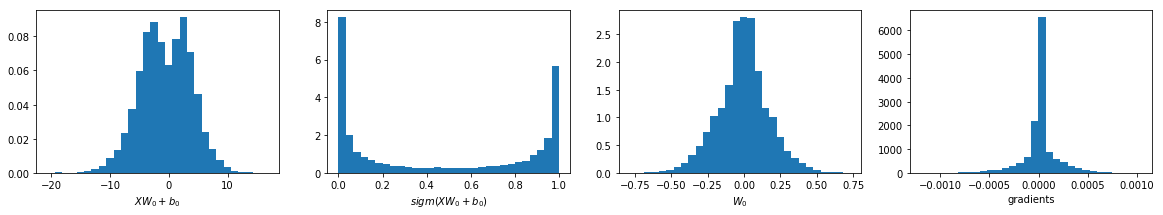

In [35]:
show_layer0_output()